In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [147]:
train = pd.read_csv('./data/full_df3.csv')
del train['Unnamed: 0']
del train['RECEIPT_NUMBER']
del train['REPAIR_PERIOD']
del train['KEY_PARTS1']
del train['KEY_PARTS2']
del train['KEY_PARTS3']
del train['KEY_PARTS4']
del train['KEY_PARTS5']
del train['PARTS_NO1']
del train['PARTS_NO2']
del train['PARTS_NO3']
del train['PARTS_NO4']
del train['PARTS_NO5']

/tmp/ipykernel_1856846/3843417555.py:1: DtypeWarning: Columns (12,13,14,15,16,17,20,22,30,43) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('./full_df3.csv')


In [148]:
train['ENGINEER_REPAIR'].unique()

array(['Module/Array/Open Cell Replacement', 'Parts replaced',
       'Installation of new product', 'Sealed System Repair',
       'Part replaced-mechanical (ref#)', 'Demo given',
       'Compressor Replaced', 'Gas Charging',
       'Wet/Preventive Maintenance', 'Accessory Sale'], dtype=object)

In [124]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train["Set"]=="train"].index
valid_indices = train[train["Set"]=="valid"].index
test_indices = train[train["Set"]=="test"].index

In [125]:
train.columns[32]

'ENGINEER_REPAIR'

In [126]:
train_indices

Index([     0,      1,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       578741, 578742, 578743, 578744, 578745, 578746, 578747, 578749, 578750,
       578751],
      dtype='int64', length=462936)

In [149]:
target = train.columns[32]
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object':
        train[col] = train[col].astype(str)
        print(col, train[col].nunique())
        train[col] = train[col].fillna("VV_likely")
        l_enc = LabelEncoder()
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

int64
float64
object
SUBSIDIARY_NAME 2
object
CAPTIVE_CHANNEL_FLAG 2
object
COMPANY_CODE 3
object
DIVISION_NAME 8
object
MODEL_CODE 69
object
PREV_PARTS_NO1 571
object
PREV_PARTS_NO2 325
object
PREV_PARTS_NO3 220
object
PREV_PARTS_NO4 118
object
PREV_PARTS_NO5 62
object
RECEIPT_SYMPTOM 101
object
PREV_RECEIPT_NUMBER 15895
object
CENTER_CODE 1571
object
PREV_CENTER_CODE 1025
object
PRODUCT_NAME 11
int64
object
WARRANTY_TYPE 7
object
PREV_WARRANTY_TYPE 8
object
SVC_TYPE 7
object
PREV_SVC_TYPE 7
object
ENGINEER_CODE 12246
object
PREV_ENGINEER_CODE 5591
object
PREV_ENGINEER_REPAIR 59
int64
int64
int64
int64
int64
int64
object
PREV_RECEIPT_SYMPTOM 88
object
ENGINEER_REPAIR 10


In [150]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [152]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax'
                      )

/home/js/.conda/envs/LG/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
max_epochs = 20
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=100,
    batch_size=16384, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug
)

In [158]:
from sklearn.metrics import accuracy_score

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_acc}")

BEST VALID SCORE : 0.9442011997517755
FINAL TEST SCORE : 0.946526191959034


In [163]:
train['ENGINEER_REPAIR'] = l_enc.fit_transform(train['ENGINEER_REPAIR'])
print(train['ENGINEER_REPAIR'].unique())
train['ENGINEER_REPAIR'] = l_enc.inverse_transform(train['ENGINEER_REPAIR'])
print(train['ENGINEER_REPAIR'].unique())

[5 7 4 8 6 2 1 3 9 0]
['Module/Array/Open Cell Replacement' 'Parts replaced'
 'Installation of new product' 'Sealed System Repair'
 'Part replaced-mechanical (ref#)' 'Demo given' 'Compressor Replaced'
 'Gas Charging' 'Wet/Preventive Maintenance' 'Accessory Sale']


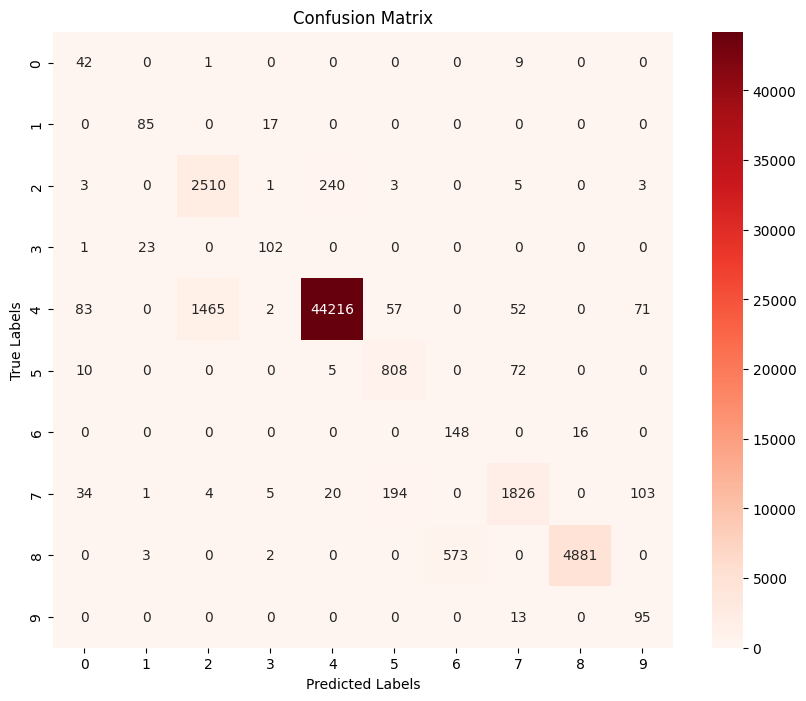

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

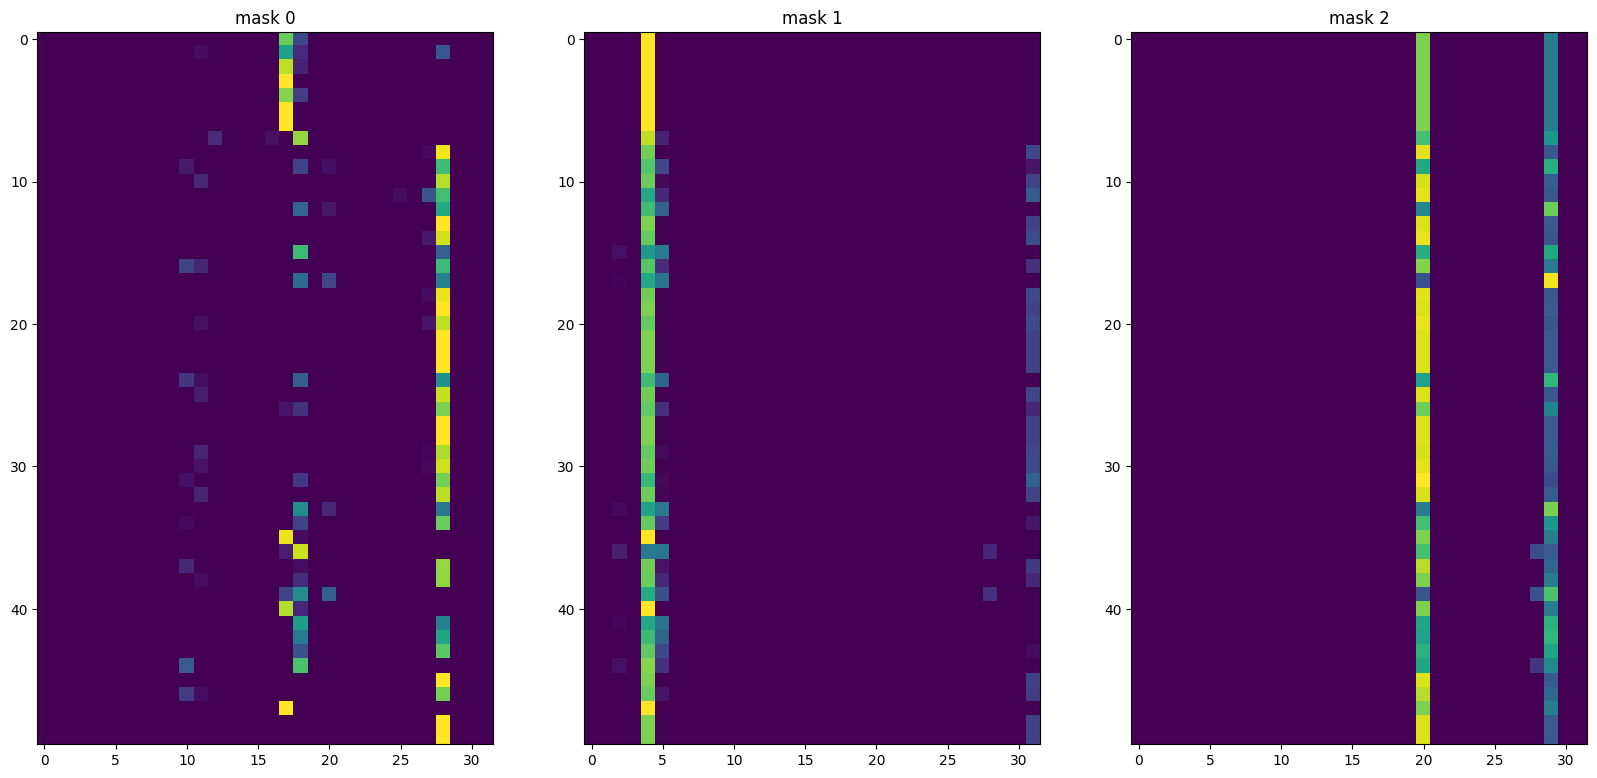

In [165]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [171]:
train.columns[4]

'COMPANY_CODE'

<Axes: >

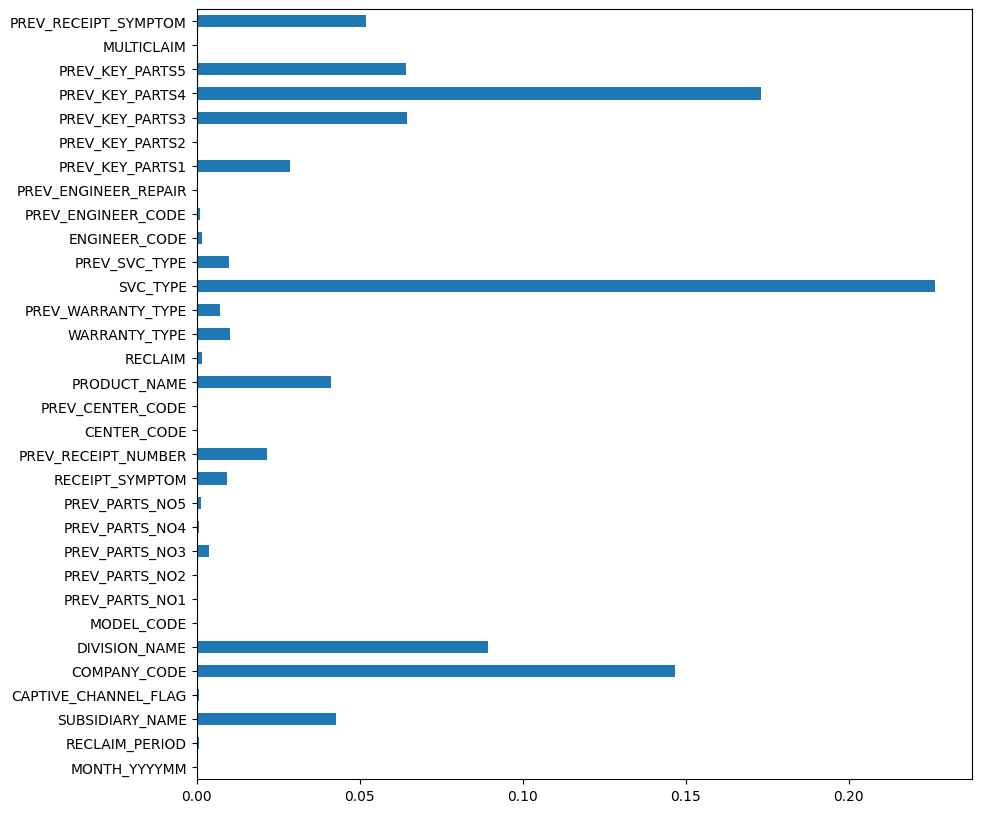

In [172]:
# global
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh', figsize=(10,10))
